# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from pandas.plotting import scatter_matrix
from sklearn.dummy import DummyClassifier

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv(url)

In [3]:
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [6]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


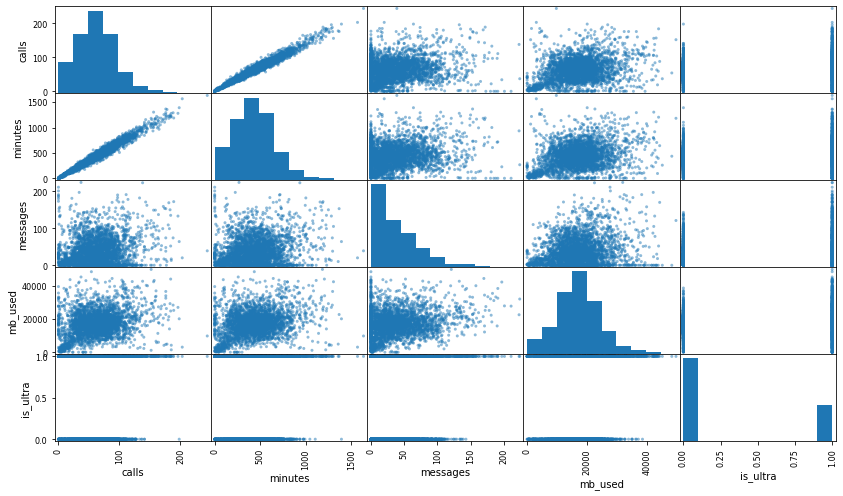

In [7]:
scatter_matrix(df, figsize=(14,8));

Так как в тарифе есть ограничение по `minutes`, а по `calls` нет, дропнем столбец `calls`.

In [8]:
df = df.drop('calls', axis=1)

### Вывод

Так как признаки `calls` и `minutes` почти одинаковы убрали `calls`.

## Разбейте данные на выборки

In [9]:
features_train = df.drop('is_ultra', axis=1)
target_train = df['is_ultra']

In [10]:
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, 
                                                                              stratify=target_train, test_size=0.4, 
                                                                              random_state=12345)

In [11]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, 
                                                                              stratify=target_valid, test_size=0.5, 
                                                                              random_state=12345)

In [12]:
print(target_train.shape, target_valid.shape, target_test.shape)

(1928,) (643,) (643,)


## Исследуйте модели

In [13]:
best_model = None
best_result = 0
for depth in range(1, 11):
    model_decision = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model_decision.fit(features_train, target_train) 
    predictions = model_decision.predict(features_valid)
    result = accuracy_score(target_valid, predictions) 
    if result > best_result:
        best_model_decision = model_decision
        best_result = result
print("Accuracy лучшей модели дерева решений:", best_result)

Accuracy лучшей модели дерева решений: 0.7916018662519441


In [14]:
model_logistic = LogisticRegression(random_state=12345)
model_logistic.fit(features_train, target_train) 
predictions = model_logistic.predict(features_valid) 
result = accuracy_score(target_valid, predictions) 

print("Accuracy модели логистической регрессии на валидационной выборке:", result)

Accuracy модели логистической регрессии на валидационной выборке: 0.71850699844479


In [15]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train, target_train) 
        predictions_valid = model_forest.predict(features_valid) 
        result = accuracy_score(target_valid, predictions_valid)
        if result > best_result:
            best_model_forest = model_forest
            best_result = result
            best_est = est
            best_depth = depth

print("Accuracy наилучшей модели случайного леса на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

Accuracy наилучшей модели случайного леса на валидационной выборке: 0.8133748055987559 Количество деревьев: 50 Максимальная глубина: 10


In [16]:
best_model_decision.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))

DecisionTreeClassifier(max_depth=8, random_state=12345)

In [17]:
model_logistic.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))

LogisticRegression(random_state=12345)

In [18]:
best_model_forest.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

### Вывод

После исследования моделей: дерева решений, логистической регрессии и случайного леса на валидационной выборке, с перебором параметров, лучше всего Accuracy у случайного леса.

## Проверьте модель на тестовой выборке

In [18]:
predictions_model_decision = best_model_decision.predict(features_test)
result = accuracy_score(target_test, predictions_model_decision)
print("Accuracy модели дерева решений на тестовой выборке:", result)

Accuracy модели дерева решений на тестовой выборке: 0.8055987558320373


In [19]:
predictions_model_logistic = model_logistic.predict(features_test)
result = accuracy_score(target_test, predictions_model_logistic)
print("Accuracy модели логистической регрессии на тестовой выборке:", result)

Accuracy модели логистической регрессии на тестовой выборке: 0.7060653188180405


In [20]:
predictions_model_forest = best_model_forest.predict(features_test)
result = accuracy_score(target_test, predictions_model_forest)
print("Accuracy модели случайного леса на тестовой выборке:", result)

Accuracy модели случайного леса на тестовой выборке: 0.8211508553654744


### Вывод

После проверки на тестовой выборке опять лучше всего показал себя случайный лес.

## (бонус) Проверьте модели на адекватность

В тренажере написано: чтобы оценить адекватность модели в задачах классификации, нужно сравнить её со случайной. Я не понимаю с какой случайной надо её сравнить и нашел в интернете самое понятное для меня classification_report.

In [21]:
predictions_test = best_model_decision.predict(features_test) 
print(classification_report(target_test, predictions_test))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       446
           1       0.83      0.46      0.59       197

    accuracy                           0.81       643
   macro avg       0.81      0.71      0.73       643
weighted avg       0.81      0.81      0.79       643



In [22]:
predictions_test = model_logistic.predict(features_test) 
print(classification_report(target_test, predictions_test))

              precision    recall  f1-score   support

           0       0.70      0.99      0.82       446
           1       0.79      0.06      0.10       197

    accuracy                           0.71       643
   macro avg       0.75      0.52      0.46       643
weighted avg       0.73      0.71      0.60       643



In [23]:
predictions_test = best_model_forest.predict(features_test) 
print(classification_report(target_test, predictions_test))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       446
           1       0.79      0.56      0.66       197

    accuracy                           0.82       643
   macro avg       0.81      0.75      0.77       643
weighted avg       0.82      0.82      0.81       643



Лучше всего всё выглядит у случайного леса

In [25]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [26]:
dummy_clf.score(features_test, target_test)

0.6936236391912908

Так как скор у случайного леса отличается от скора DummyClassifier в лучшую сторону, можно сказать что модель адекватна)

## Общий вывод

- Из данных был убран признак `calls`.
- Данные разбиты на 60% train и по 20% на valid и test.
- Исследованны модели дерева решений, логистической регрессии и случайного леса.
- Лучше всего accuracy у случайного леса как на валидационной выборке, так и на тестовой выборке.